In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [16]:
pd.set_option('display.max_columns', None)  # Zobrazení všech sloupců
pd.set_option('display.width', 200)  # Zvýšení maximální šířky řádku

def load_signal_data(file_path):
    """ Načte signál ze souboru a extrahuje časovou osu a měření """
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    # Hledání prvního řádku s číselnými hodnotami (přeskakujeme metadata)
    for i, line in enumerate(lines):
        numeric_values = [word for word in line.split(",") if word.replace(".", "", 1).isdigit()]
        if len(numeric_values) > 2:  # Čekáme minimálně tři číselné hodnoty
            data_start_index = i
            break
    
    # Načtení dat od nalezeného indexu
    df = pd.read_csv(file_path, skiprows=data_start_index, header=None)
    df.columns = ["Year", "Month", "Day", "Hour", "Minute", "Second", "Measurement"]
    
    # Převod na číselné hodnoty a odstranění nečíselných řádků
    df = df[pd.to_numeric(df["Measurement"], errors="coerce").notna()]
    df["Measurement"] = df["Measurement"].astype(float)
    
    # Zajištění, že hodnoty pro rok, měsíc a den jsou celá čísla
    year = int(df["Year"].iloc[0])
    month = int(df["Month"].iloc[0])
    day = int(df["Day"].iloc[0])
    
    return year, month, day, df["Measurement"]

def compute_statistics(directory):
    """ Spočítá statistické hodnoty pro každý soubor v daném adresáři """
    stats = []
    
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path) and file_name.endswith(".csv"):
            try:
                year, month, day, signal = load_signal_data(file_path)
                date_label = f"{year}-{month:02d}-{day:02d}"
                area_under_curve = np.trapz(np.abs(signal))  # Výpočet plochy pod křivkou
                stats.append({
                    "Datum": date_label,
                    "Průměr": np.mean(signal),
                    "Maximum": np.max(signal),
                    "Minimum": np.min(signal),
                    "Směrodatná odchylka": np.std(signal),
                    "Plocha pod křivkou": area_under_curve
                })
            except Exception as e:
                print(f"Chyba při zpracování souboru {file_name}: {e}")
    
    df_stats = pd.DataFrame(stats)
    df_stats.sort_values(by="Datum", inplace=True)
    return df_stats

# Adresář se soubory
directory = "/scratch/kakl/vetrniky/efm/"

# Výpočet statistik
statistics = compute_statistics(directory)

# Zobrazení výsledků
print(statistics)


         Datum     Průměr  Maximum  Minimum  Směrodatná odchylka  Plocha pod křivkou
3   2023-02-01  63.571414   3556.9  -3529.0           544.574247         16395772.85
0   2023-03-25 -82.650862   3556.9  -3529.0           417.675818         16801692.45
7   2023-03-30  25.476497   3556.9  -3529.0           457.792556         16056198.55
15  2023-06-07  -0.059490    333.7   -363.3            53.765970          1619719.20
16  2023-06-15   0.920291    190.7   -214.3            17.088237           671335.65
5   2023-06-22   0.168354    559.8   -500.1            63.161806          2014097.25
9   2023-06-30   6.280406   3553.6  -3336.9           197.692438          6070907.55
12  2023-07-11  23.608135   1390.4  -3432.0           136.235316          2724801.45
2   2023-07-16  23.745847   2028.2  -2521.0           248.244703          7332155.00
1   2023-07-24  18.161295   1668.9  -1797.5           154.941212          5790693.25
13  2023-07-25  56.615413   3556.9  -3529.0           451.870623 

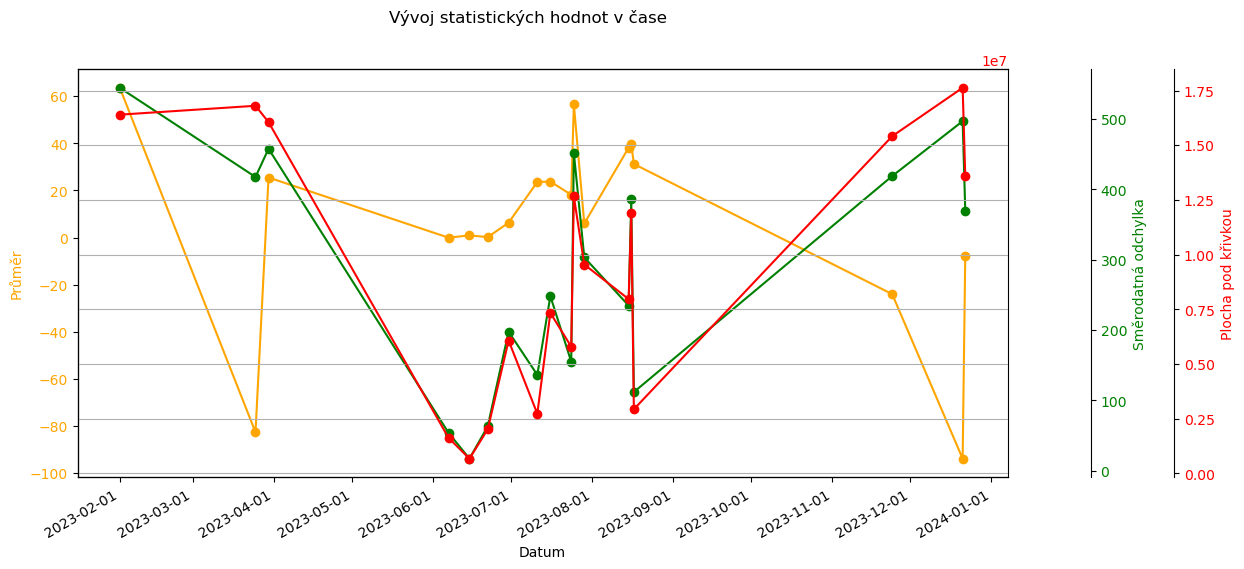

In [20]:
def plot_statistics(statistics, columns_to_plot=None):
    """ Vykreslí vybrané statistiky v grafu s oddělenými osami Y """
    statistics = statistics.copy()
    statistics["Datum"] = pd.to_datetime(statistics["Datum"])
    statistics.set_index("Datum", inplace=True)
    
    if columns_to_plot is None:
        columns_to_plot = ["Průměr", "Směrodatná odchylka", "Plocha pod křivkou"]
    
    colors = ['orange', 'green', 'red']
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("Datum")
    ax_list = [ax1]
    
    for i, column in enumerate(columns_to_plot):
        if column in statistics:
            if i == 0:
                ax = ax1
            else:
                ax = ax1.twinx()
                ax.spines['right'].set_position(('outward', 60 * i))
                ax_list.append(ax)
            
            color = colors[i % len(colors)]
            ax.set_ylabel(column, color=color)
            ax.plot(statistics.index, statistics[column], marker='o', label=column, color=color)
            ax.tick_params(axis='y', labelcolor=color)
    
    fig.suptitle("Vývoj statistických hodnot v čase")
    fig.autofmt_xdate()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.grid(True)
    plt.show()

plot_statistics(statistics)

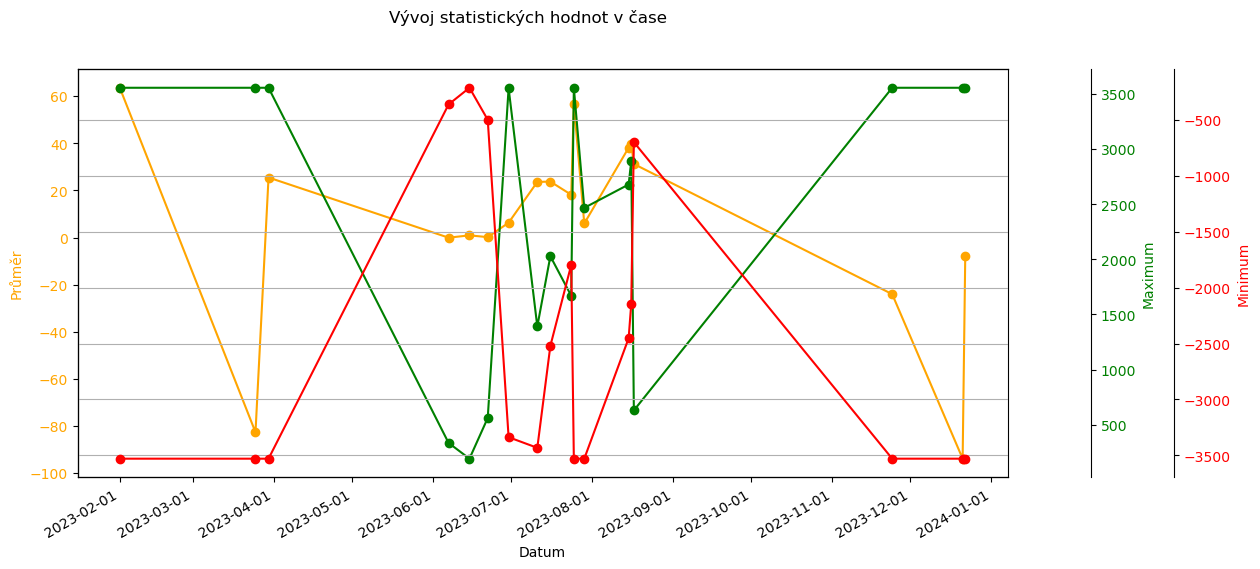

In [30]:
def plot_statistics(statistics, columns_to_plot=None):
    """ Vykreslí vybrané statistiky v grafu s oddělenými osami Y """
    statistics = statistics.copy()
    statistics["Datum"] = pd.to_datetime(statistics["Datum"])
    statistics.set_index("Datum", inplace=True)
    
    if columns_to_plot is None:
        columns_to_plot = ["Průměr", "Maximum", "Minimum"]
    
    colors = ['orange', 'green', 'red']
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("Datum")
    ax_list = [ax1]
    
    for i, column in enumerate(columns_to_plot):
        if column in statistics:
            if i == 0:
                ax = ax1
            else:
                ax = ax1.twinx()
                ax.spines['right'].set_position(('outward', 60 * i))
                ax_list.append(ax)
            
            color = colors[i % len(colors)]
            ax.set_ylabel(column, color=color)
            ax.plot(statistics.index, statistics[column], marker='o', label=column, color=color)
            ax.tick_params(axis='y', labelcolor=color)
            #ax.set_yscale('symlog')
    
    fig.suptitle("Vývoj statistických hodnot v čase")
    fig.autofmt_xdate()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.grid(True)
    plt.show()

plot_statistics(statistics)

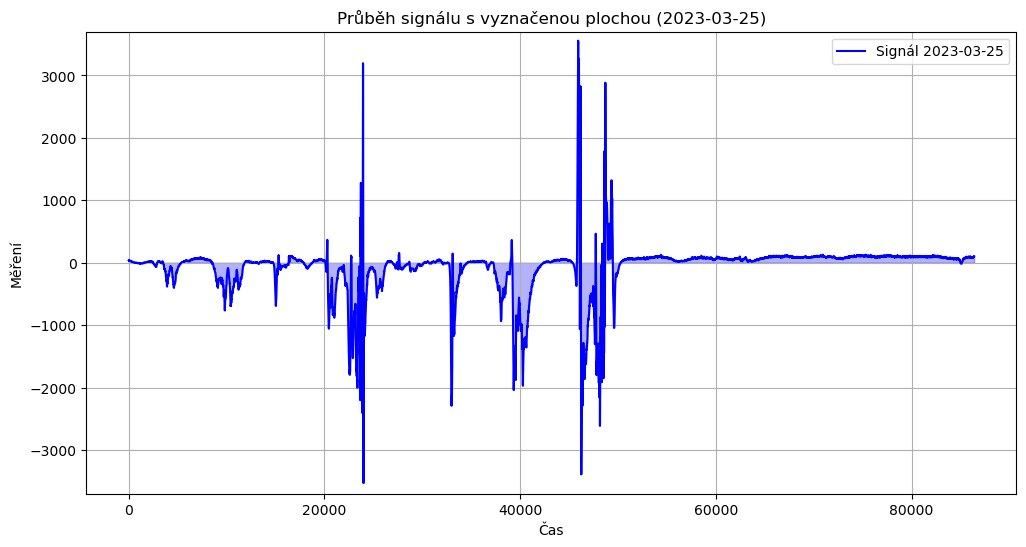

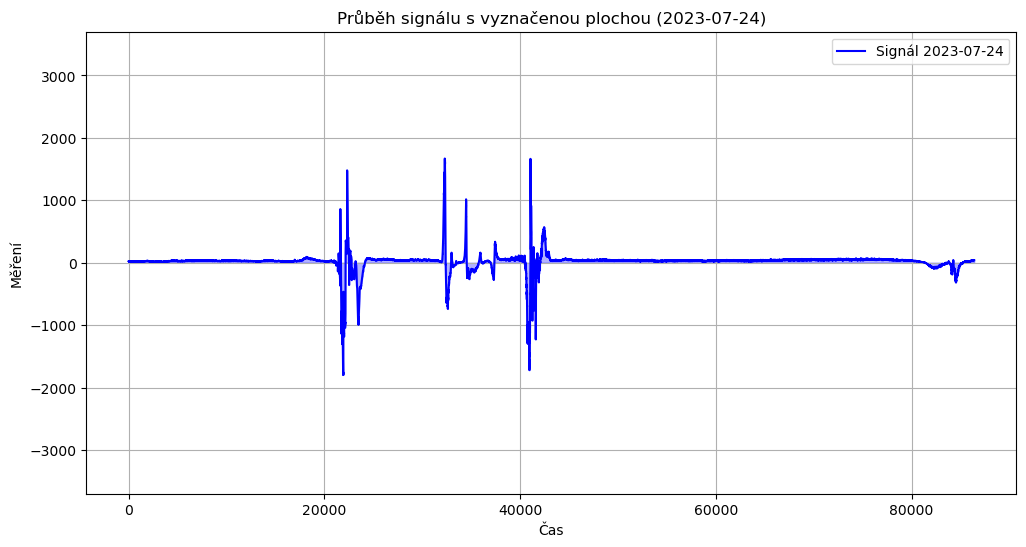

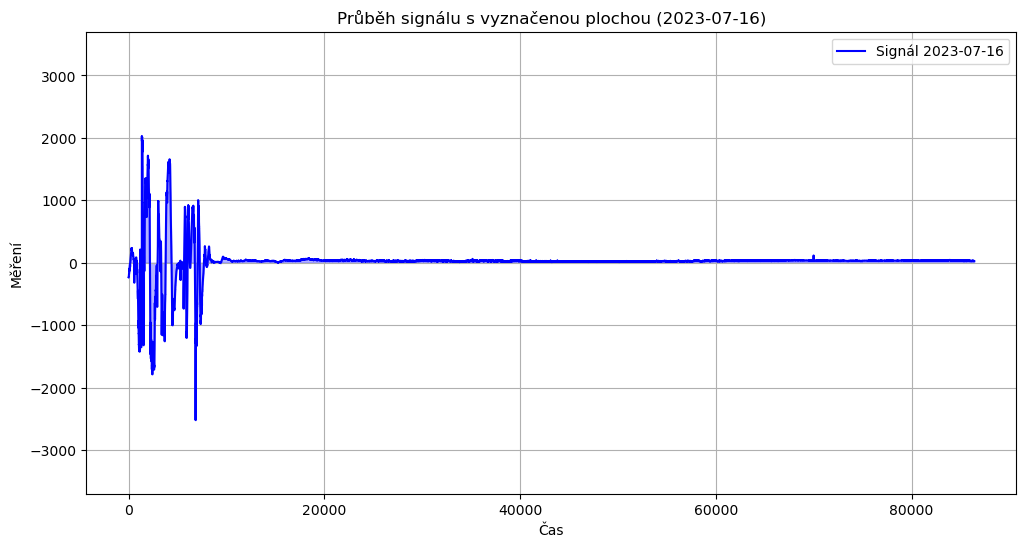

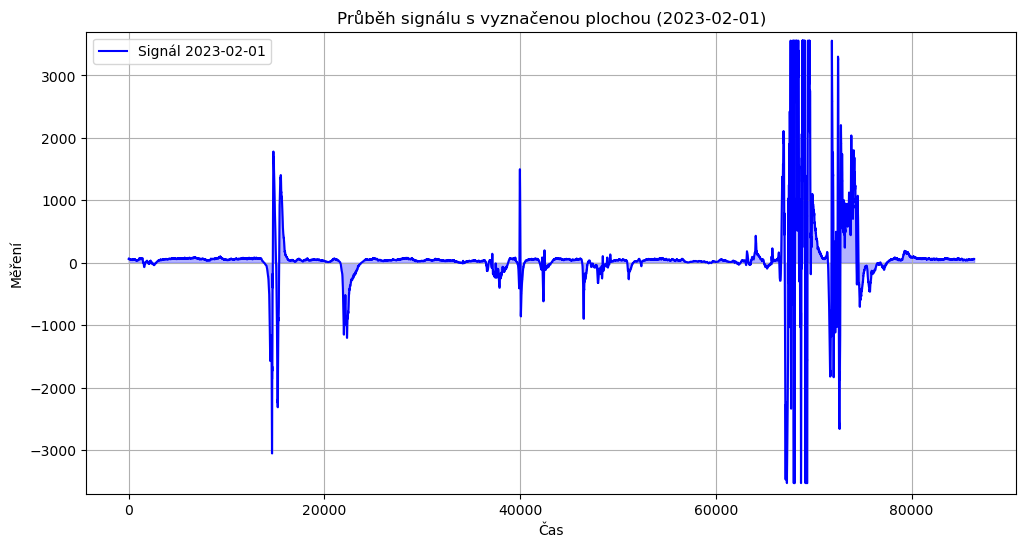

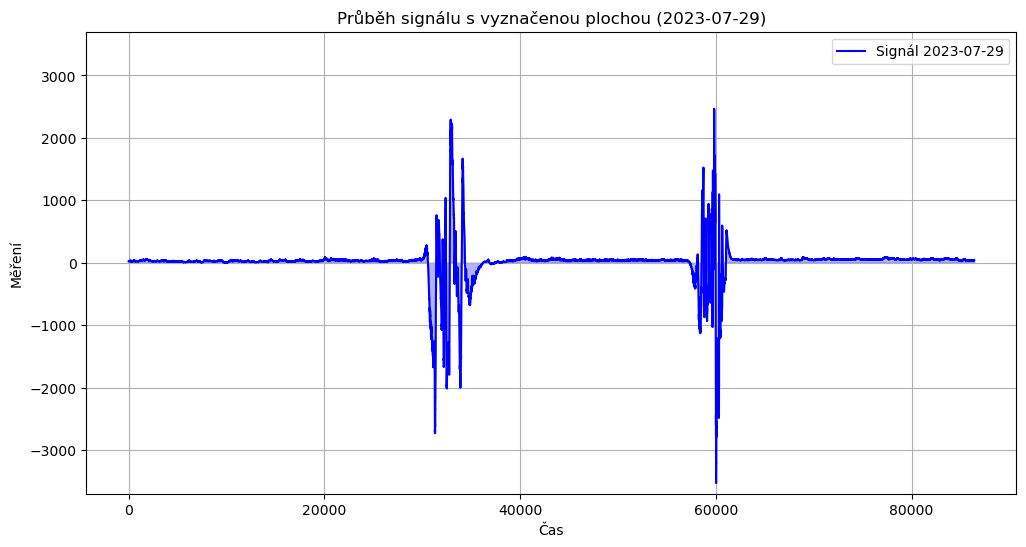

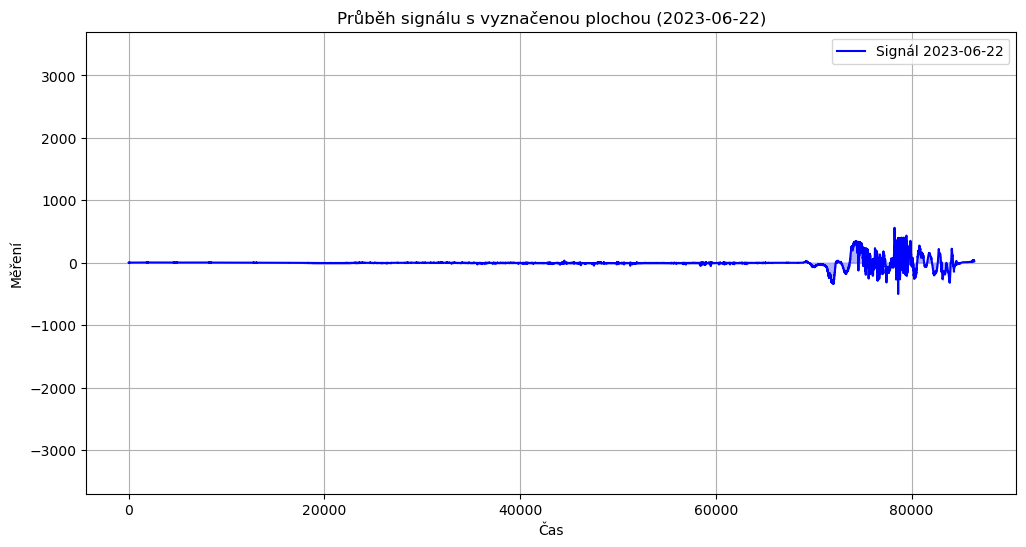

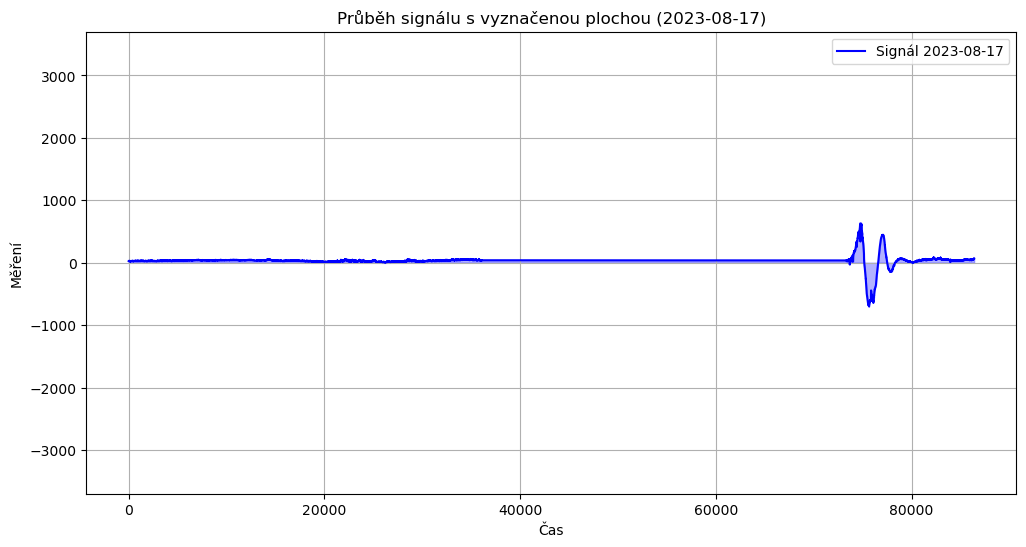

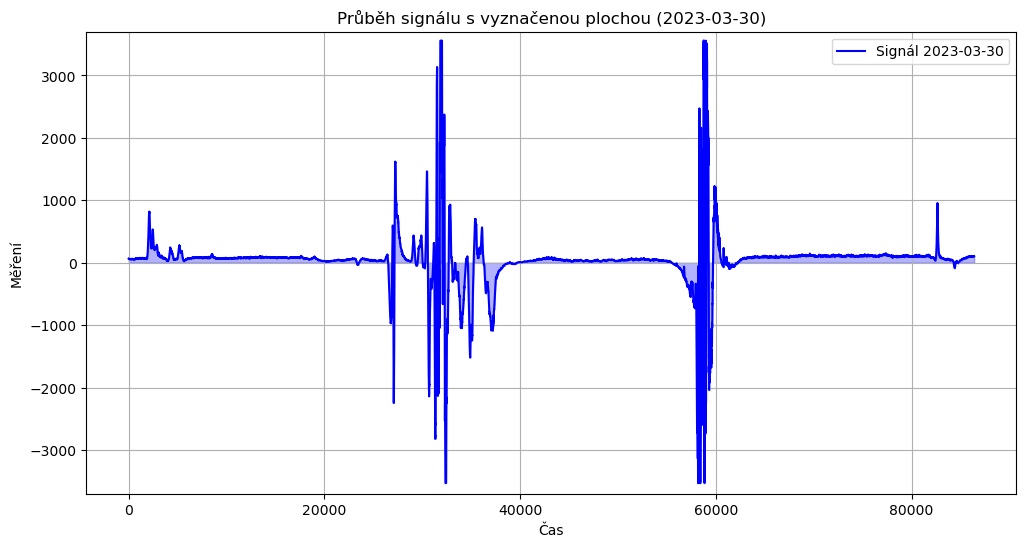

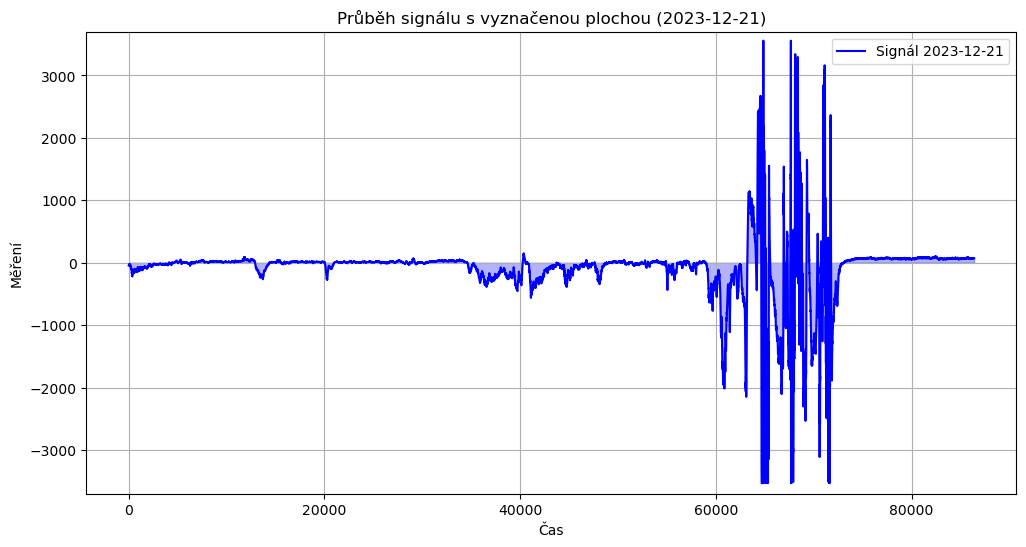

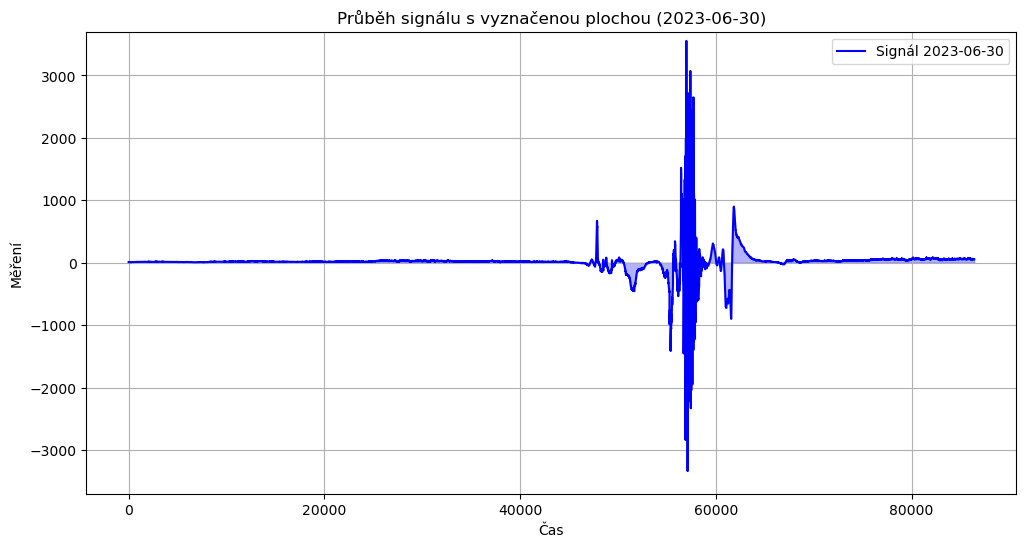

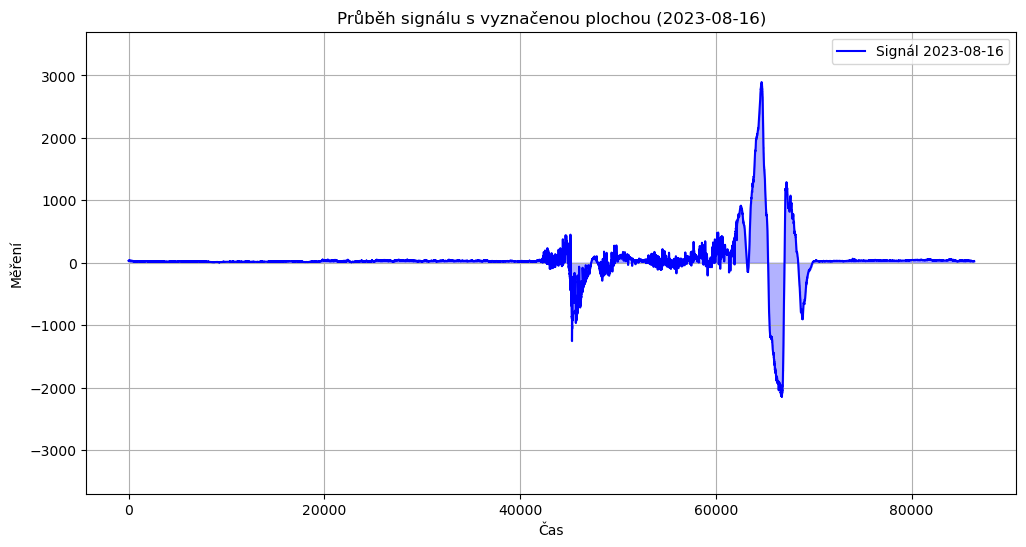

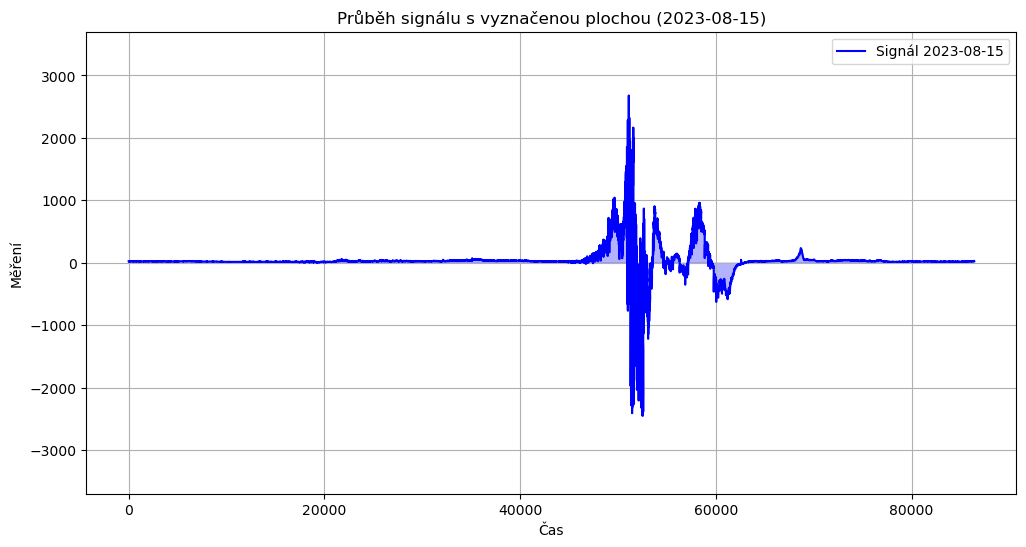

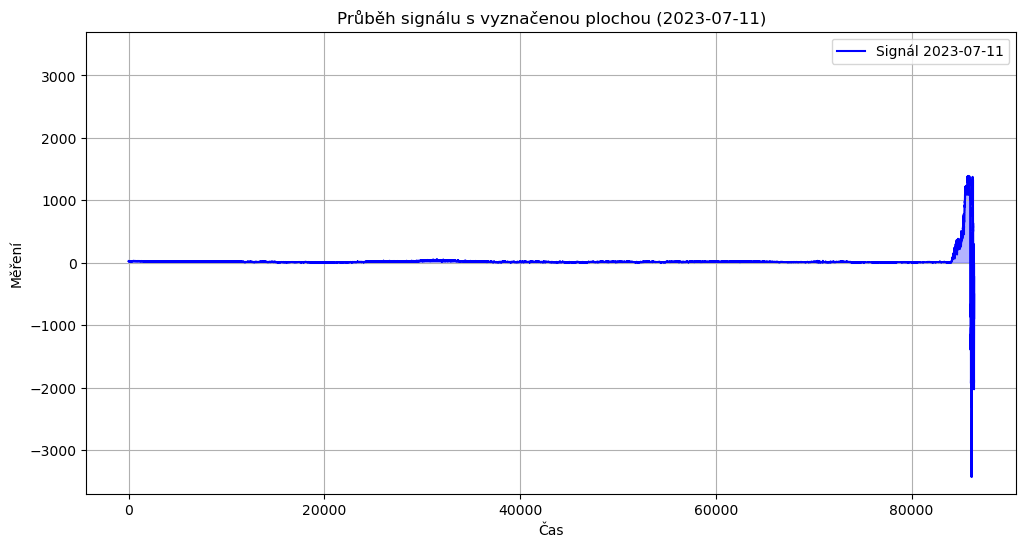

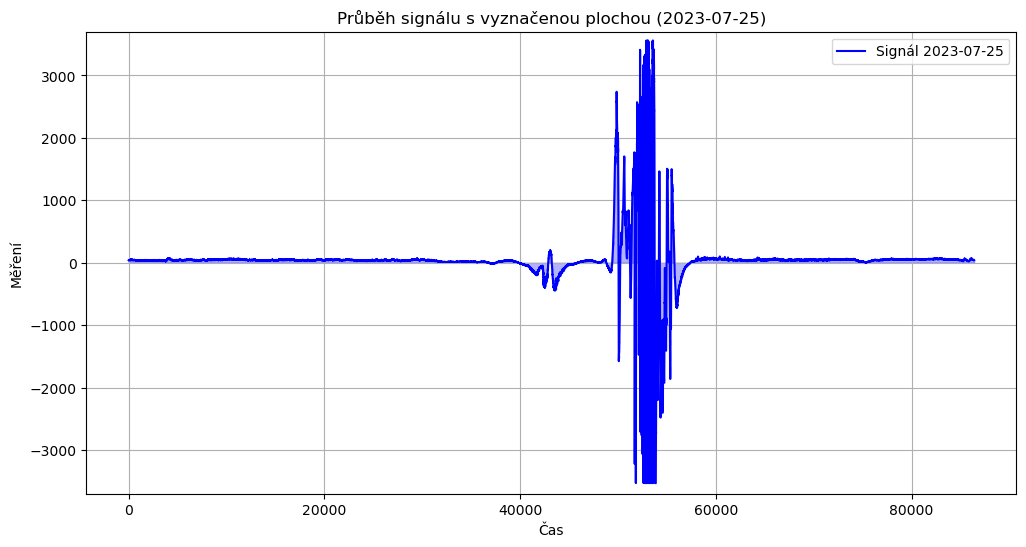

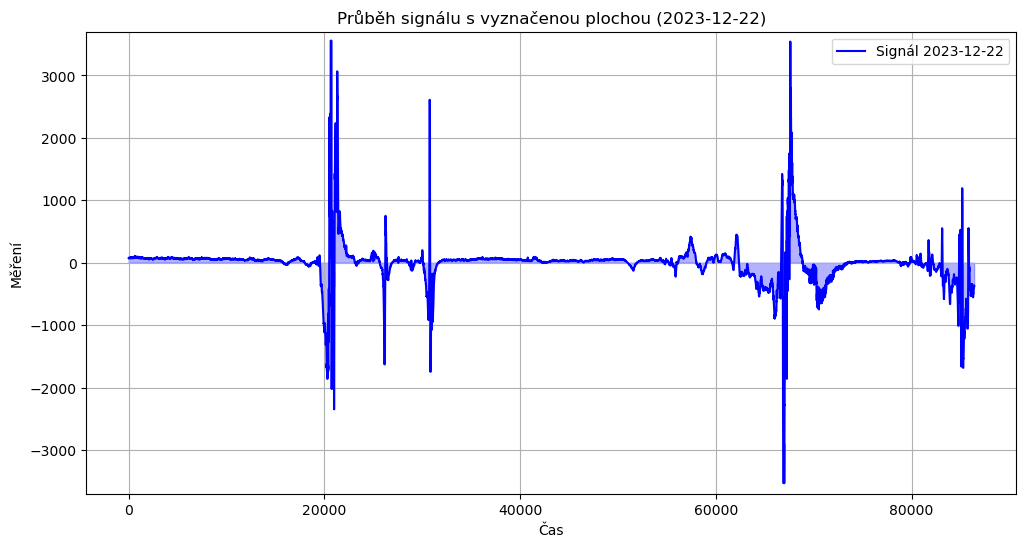

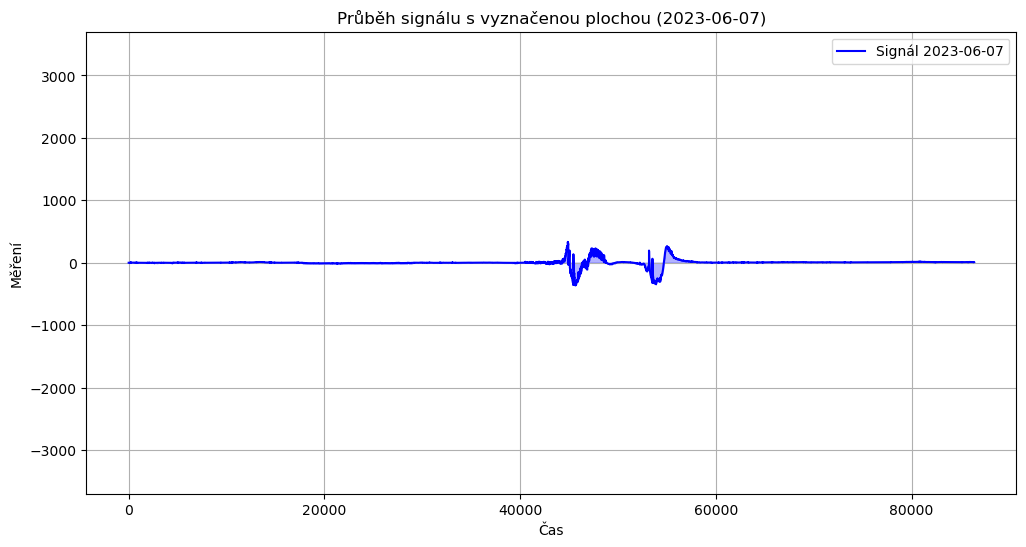

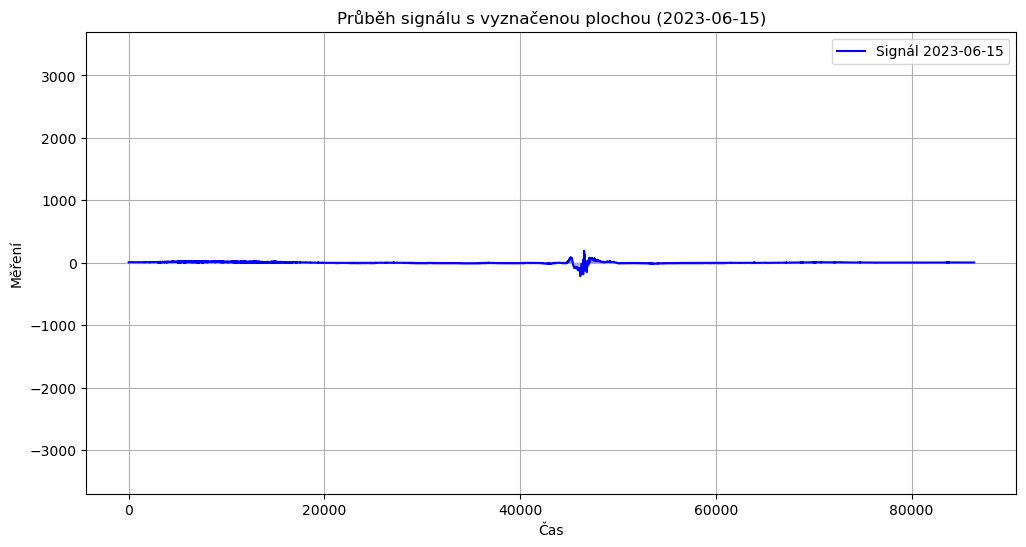

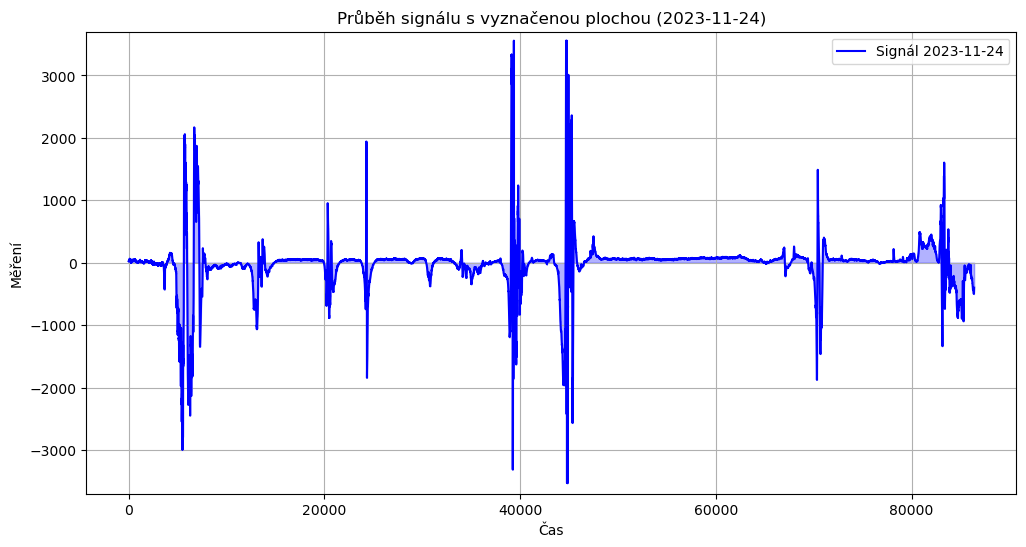

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  # Zobrazení všech sloupců
pd.set_option('display.width', 200)  # Zvýšení maximální šířky řádku

def load_signal_data(file_path):
    """ Načte signál ze souboru a extrahuje časovou osu a měření """
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    # Hledání prvního řádku s číselnými hodnotami (přeskakujeme metadata)
    for i, line in enumerate(lines):
        numeric_values = [word for word in line.split(",") if word.replace(".", "", 1).isdigit()]
        if len(numeric_values) > 2:  # Čekáme minimálně tři číselné hodnoty
            data_start_index = i
            break
    
    # Načtení dat od nalezeného indexu
    df = pd.read_csv(file_path, skiprows=data_start_index, header=None)
    df.columns = ["Year", "Month", "Day", "Hour", "Minute", "Second", "Measurement"]
    
    # Převod na číselné hodnoty a odstranění nečíselných řádků
    df = df[pd.to_numeric(df["Measurement"], errors="coerce").notna()]
    df["Measurement"] = df["Measurement"].astype(float)
    
    # Zajištění, že hodnoty pro rok, měsíc a den jsou celá čísla
    year = int(df["Year"].iloc[0])
    month = int(df["Month"].iloc[0])
    day = int(df["Day"].iloc[0])
    
    return year, month, day, df

def plot_signal_with_area(file_path):
    """ Vykreslí průběh signálu a vyznačí plochu pod křivkou """
    year, month, day, df = load_signal_data(file_path)
    date_label = f"{year}-{month:02d}-{day:02d}"
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Measurement"], label=f"Signál {date_label}", color='b')
    plt.fill_between(df.index, df["Measurement"], alpha=0.3, color='blue')
    
    plt.xlabel("Čas")
    plt.ylabel("Měření")
    plt.title(f"Průběh signálu s vyznačenou plochou ({date_label})")
    plt.legend()
    plt.grid(True)
    plt.ylim(-3700, 3700)
    plt.show()

# Adresář se soubory
directory = "/scratch/kakl/vetrniky/efm/"

# Projití všech souborů a vykreslení jejich průběhů
for file_name in os.listdir(directory):
    file_path = os.path.join(directory, file_name)
    if os.path.isfile(file_path) and file_name.endswith(".csv"):
        plot_signal_with_area(file_path)


In [33]:
pd.set_option('display.max_columns', None)  # Zobrazení všech sloupců
pd.set_option('display.width', 200)  # Zvýšení maximální šířky řádku

def load_signal_data(file_path):
    """ Načte signál ze souboru a extrahuje časovou osu a měření """
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    # Hledání prvního řádku s číselnými hodnotami (přeskakujeme metadata)
    for i, line in enumerate(lines):
        numeric_values = [word for word in line.split(",") if word.replace(".", "", 1).isdigit()]
        if len(numeric_values) > 2:  # Čekáme minimálně tři číselné hodnoty
            data_start_index = i
            break
    
    # Načtení dat od nalezeného indexu
    df = pd.read_csv(file_path, skiprows=data_start_index, header=None)
    df.columns = ["Year", "Month", "Day", "Hour", "Minute", "Second", "Measurement"]
    
    # Převod na číselné hodnoty a odstranění nečíselných řádků
    df = df[pd.to_numeric(df["Measurement"], errors="coerce").notna()]
    df["Measurement"] = df["Measurement"].astype(float)
    
    # Zajištění, že hodnoty pro rok, měsíc a den jsou celá čísla
    year = int(df["Year"].iloc[0])
    month = int(df["Month"].iloc[0])
    day = int(df["Day"].iloc[0])
    
    # Výpočet doby, po kterou signál dosahuje specifických hodnot
    duration_3556_9 = (df["Measurement"] == 3556.9).sum()
    duration_neg_3529_0 = (df["Measurement"] == -3529.0).sum()
    
    return year, month, day, df["Measurement"], duration_3556_9, duration_neg_3529_0

def compute_statistics(directory):
    """ Spočítá statistické hodnoty pro každý soubor v daném adresáři """
    stats = []
    
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path) and file_name.endswith(".csv"):
            try:
                year, month, day, signal, duration_3556_9, duration_neg_3529_0 = load_signal_data(file_path)
                date_label = f"{year}-{month:02d}-{day:02d}"
                area_under_curve = np.trapz(np.abs(signal))  # Výpočet plochy pod křivkou
                stats.append({
                    "Datum": date_label,
                    "Průměr": np.mean(signal),
                    "Maximum": np.max(signal),
                    "Minimum": np.min(signal),
                    "Směrodatná odchylka": np.std(signal),
                    "Plocha pod křivkou": area_under_curve,
                    "Doba 3556.9": duration_3556_9,
                    "Doba -3529.0": duration_neg_3529_0,
                    "Amplitude": np.max(signal) + abs(np.min(signal))
                })
            except Exception as e:
                print(f"Chyba při zpracování souboru {file_name}: {e}")
    
    df_stats = pd.DataFrame(stats)
    df_stats.sort_values(by="Datum", inplace=True)
    return df_stats

# Adresář se soubory
directory = "/scratch/kakl/vetrniky/efm/"

# Výpočet statistik
statistics = compute_statistics(directory)

# Zobrazení výsledků
print(statistics)


         Datum     Průměr  Maximum  Minimum  Směrodatná odchylka  Plocha pod křivkou  Doba 3556.9  Doba -3529.0  Amplitude
3   2023-02-01  63.571414   3556.9  -3529.0           544.574247         16395772.85          624           166     7085.9
0   2023-03-25 -82.650862   3556.9  -3529.0           417.675818         16801692.45            7            18     7085.9
7   2023-03-30  25.476497   3556.9  -3529.0           457.792556         16056198.55          192           144     7085.9
15  2023-06-07  -0.059490    333.7   -363.3            53.765970          1619719.20            0             0      697.0
16  2023-06-15   0.920291    190.7   -214.3            17.088237           671335.65            0             0      405.0
5   2023-06-22   0.168354    559.8   -500.1            63.161806          2014097.25            0             0     1059.9
9   2023-06-30   6.280406   3553.6  -3336.9           197.692438          6070907.55            0             0     6890.5
12  2023-07-11  